# Classification of b-quark jets in the Aleph simulated data

Python macro for selecting b-jets (sprays of particles with a b-quark in it) in Aleph Z -> qqbar MC (i.e. simulated decays of the Z0 boson decaying to a quark and an anti-quark) using Machine Learning (ML) methods. We will in this example show **a Boosted Decision Tree (BDT) based methods**, and see how complicated and time consuming (or not) it is to get a good solution.

Once you obtain a classification of b-jets vs. non-b-jets, think about how to quantify the quality of your algorithm. Also, try to compare it to the NN result of the Aleph collaboration, given by the variable "nnbjet". It is based on a neural network with 6 input variables (prob_b, spheri, pt2rel, multip, bqvjet, and ptlrel), and two hidden layers each with 10 nodes in. Can you do better?


### Data:
The input variables (X) are (where Aleph uses only the first six):
* **prob_b**: Probability of being a b-jet from the pointing of the tracks to the vertex.
* **spheri**: Sphericity of the event, i.e. how spherical it is.
* **pt2rel**: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* **multip**: Multiplicity of the jet (in a relative measure).
* **bqvjet**: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* **ptlrel**: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).

The target variable (Y) is:
* isb:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net (6 input variables, two hidden layers with 10 neurons in each, and 1 output varible) based classification variable, which you can compare to (and compete with?):
* nnbjet: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).


### Task:
Thus, the task before you is to produce functions (i.e. ML algorithm), which given the input variables X provides an output variable estimate, Y_est, which is "closest possible" to the target variable, Y. The "closest possible" is left to the user to define in a _Loss Function_, which we have discussed. In classification problems (such as this), the typical loss function to use "Cross Entropy", see https://en.wikipedia.org/wiki/Cross_entropy.

Try increasing the size of the training sample, and consider the time consumption and performance.

* Author: Troels C. Petersen (NBI)
* Email:  petersen@nbi.dk
* Date:   27th of September 2024

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv

Possible other packages to consider:
cornerplot, seaplot, sklearn.decomposition(PCA)

In [2]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

# Introduction to a Tree based ML solution

The following is a solution based on LightGBM. Examples of different code solutions can be found here:
* https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py
* https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python

Generally, the steps are:
1. Define training, validation, and testing samples.
2. Define the feature (input) and target (output) variables.
3. Define the loss function (i.e. what it should aim to optimize).
4. Fit for a model.
5. Apply the model to the test set, and determine performance.

A few worlds on the variables and feature choices:
* 'isb' is our binary truth variables. If isb = 1 then it's a b-quark and isb = 0 if it is not.
   Because this is our truth, we must not include it as the input to our model.
* 'nnbjet' is our "competitor" e.g. a model we are supposed to benchmark against.
   Therefore 'nnbjet' shouldn't be in our input either.
* 'energy', 'cTheta', and 'phi' are kinematic variables of the jet, and not about the jet type.
   Though they might help, they were not in the original Aleph NN (nnbjet), and to compare, we omit them.

Usually one would apply further checks/regularization/standardization of data at this step, but this data has already been "prepared", so we'll move onto seperate the data into input, truth, and benchmark:

In [3]:
# We import the data slightly more convenient here
import pandas as pd 
from pandas import Series, DataFrame 

# Read the data in using Pandas Dataframe and print the variables:
data = pd.DataFrame(np.genfromtxt('AlephBtag_MC_train_Nev5000.csv', names=True))
#data = pd.DataFrame(np.genfromtxt('AlephBtag_MC_train_Nev50000.csv', names=True))
#data = pd.DataFrame(np.genfromtxt('AlephBtag_MC_train_Nev500000.csv', names=True))

variables = data.columns
print("  Variables used for training: \n      ", variables)

# Decide on which variables to use for input (X) and what defines the label (Y):
input_variables = variables[(variables != 'nnbjet') & (variables != 'isb') & (variables != 'energy') & (variables != 'cTheta') & (variables != 'phi')]
input_data      = data[input_variables]
truth_data      = data['isb']
benchmark_data  = data['nnbjet']
print("  Variables used for training: \n      ", input_variables)

  Variables used for training: 
       Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel', 'nnbjet', 'isb'],
      dtype='object')
  Variables used for training: 
       Index(['prob_b', 'spheri', 'pt2rel', 'multip', 'bqvjet', 'ptlrel'], dtype='object')


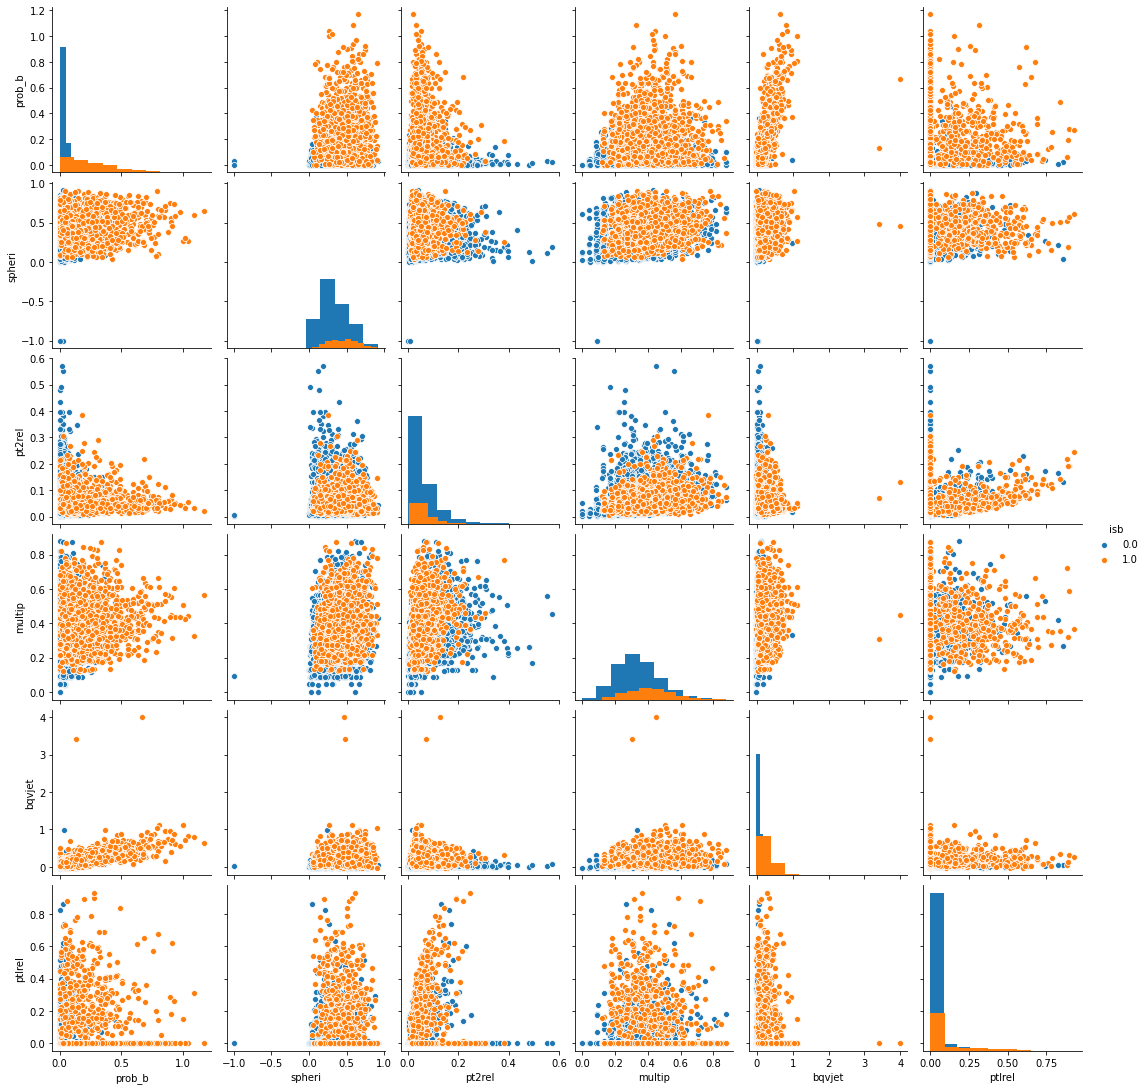

In [4]:
# 6x6 plot of the variable distributions (diagonal) and their mutual correlations (off-diagonal):
df = data.drop(['energy','cTheta','phi','nnbjet'], axis=1)  # Drop the irrelevant variables, but keep "isb" for hue

import seaborn as sns
sns.pairplot(df, hue="isb", diag_kind='hist')

***

# Classify B-jets using LightGBM:

LightGBM is one of the better tree based ML methods. It is imported along with SciKit Learn (sklearn), which has a multitude of ML methods implemented along with a lot of related methods (ROC curve, Area Under Curve (AUC), and Confusion Matrix calculations).

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from lightgbm import early_stopping
import time

start=time.time()

# Split data set into training and test set and feed these to LightGBM:
# We choose a 75:25 division here. Dataset is shuffeled before the split. 
# By using a seed number (42), it creates a random seed so you can rerun and obtain the same result.
input_train, input_test, truth_train, truth_test, benchmark_train, benchmark_test = train_test_split(input_data, truth_data, benchmark_data, test_size=0.25, random_state=42)
lgb_train = lgb.Dataset(input_train, truth_train)
lgb_eval  = lgb.Dataset(input_test,  truth_test, reference=lgb_train)

params = {
    'boosting_type': 'gbdt', # Traditional Gradient Boosting tree, we are combining many 'weak' learners here!
    'objective': 'binary',   # The outcome is binary, b-quark or not
    'num_leaves': 6,         # Set a maximum tree leaves to avoid overfitting
    'verbose':-1,            # Suppress some output
}

# Train the model:
gbm = lgb.train(params,                             # General settings (defined above)
                lgb_train,                          # Data to use for training
                num_boost_round=1000,               # How many rounds for training
                valid_sets=lgb_eval,                # Data to use for validation
                callbacks=[early_stopping(20)])     # Stops if no improvement is seen in N rounds.

# Make predictions:
y_score = gbm.predict(input_test, num_iteration=gbm.best_iteration)  # Scores are floats in the range ]0,1[.

# Print the time usage:
end = time.time()
print(f"Time used by LightGBM: {(end-start)*1000:.1f} ms")

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


[1]	valid_0's binary_logloss: 0.508366
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.471751
[3]	valid_0's binary_logloss: 0.441737
[4]	valid_0's binary_logloss: 0.419212
[5]	valid_0's binary_logloss: 0.399315
[6]	valid_0's binary_logloss: 0.383195
[7]	valid_0's binary_logloss: 0.369281
[8]	valid_0's binary_logloss: 0.356618
[9]	valid_0's binary_logloss: 0.345858
[10]	valid_0's binary_logloss: 0.335944
[11]	valid_0's binary_logloss: 0.327847
[12]	valid_0's binary_logloss: 0.320412
[13]	valid_0's binary_logloss: 0.314378
[14]	valid_0's binary_logloss: 0.308249
[15]	valid_0's binary_logloss: 0.303028
[16]	valid_0's binary_logloss: 0.298241
[17]	valid_0's binary_logloss: 0.294319
[18]	valid_0's binary_logloss: 0.290624
[19]	valid_0's binary_logloss: 0.287524
[20]	valid_0's binary_logloss: 0.284
[21]	valid_0's binary_logloss: 0.281628
[22]	valid_0's binary_logloss: 0.27937
[23]	valid_0's binary_logloss: 0.2771
[24]	valid_0's binary_logloss: 0.2

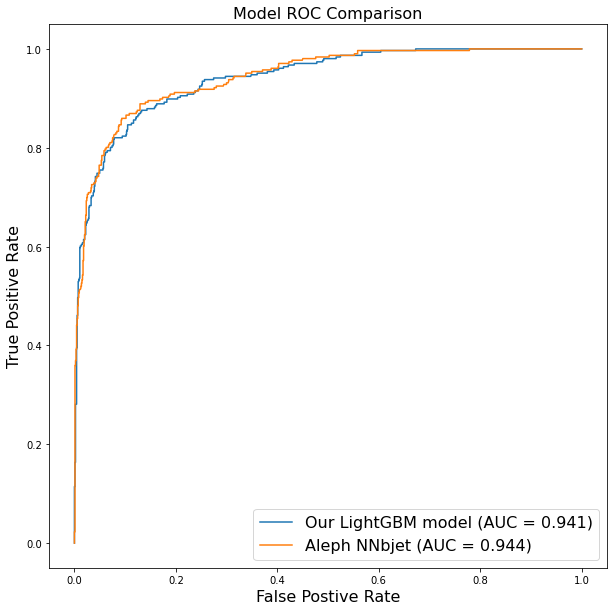

In [6]:
# Evaluate:
fpr, tpr, _ = roc_curve(truth_test, y_score)                  # False/True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_test, benchmark_test)  # False/True Positive Rate for Aleph NNbjet

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                        # This is the AUC score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)  # This is the AUC score for Aleph NNbjet

# Let's plot the ROC curves for these results:
fig = plt.figure(figsize = [10,10])
plt.title('Model ROC Comparison', size = 16)
plt.plot(fpr, tpr, label=f'Our LightGBM model (AUC = {auc_score:5.3f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'Aleph NNbjet (AUC = {auc_score_nnbjet:5.3f})')
plt.legend(fontsize=16)
plt.xlabel('False Postive Rate', size=16)
plt.ylabel('True Positive Rate', size=16)
plt.show()

# Notes about solution:

The above solution took about a second to run, works for any number of input variables, doesn't care about variable scaling or values or even if they are missing, and produces a result very close to the optimal. You gotta love it...